In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

rcParams['figure.figsize'] = 20,10

Using TensorFlow backend.


In [2]:
# Read in GS_nn_df.csv and drop na and unneeded columns

GS_NN_df = pd.read_csv('resources/GS_nn_df.csv')
GS_NN = GS_NN_df.drop(columns = ['Unnamed: 0'])
GS_NN = GS_NN.dropna(inplace=False)

GS_NN.count()

Date        1258
Open        1258
High        1258
Low         1258
Close       1258
Volume      1258
Dividend    1258
dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

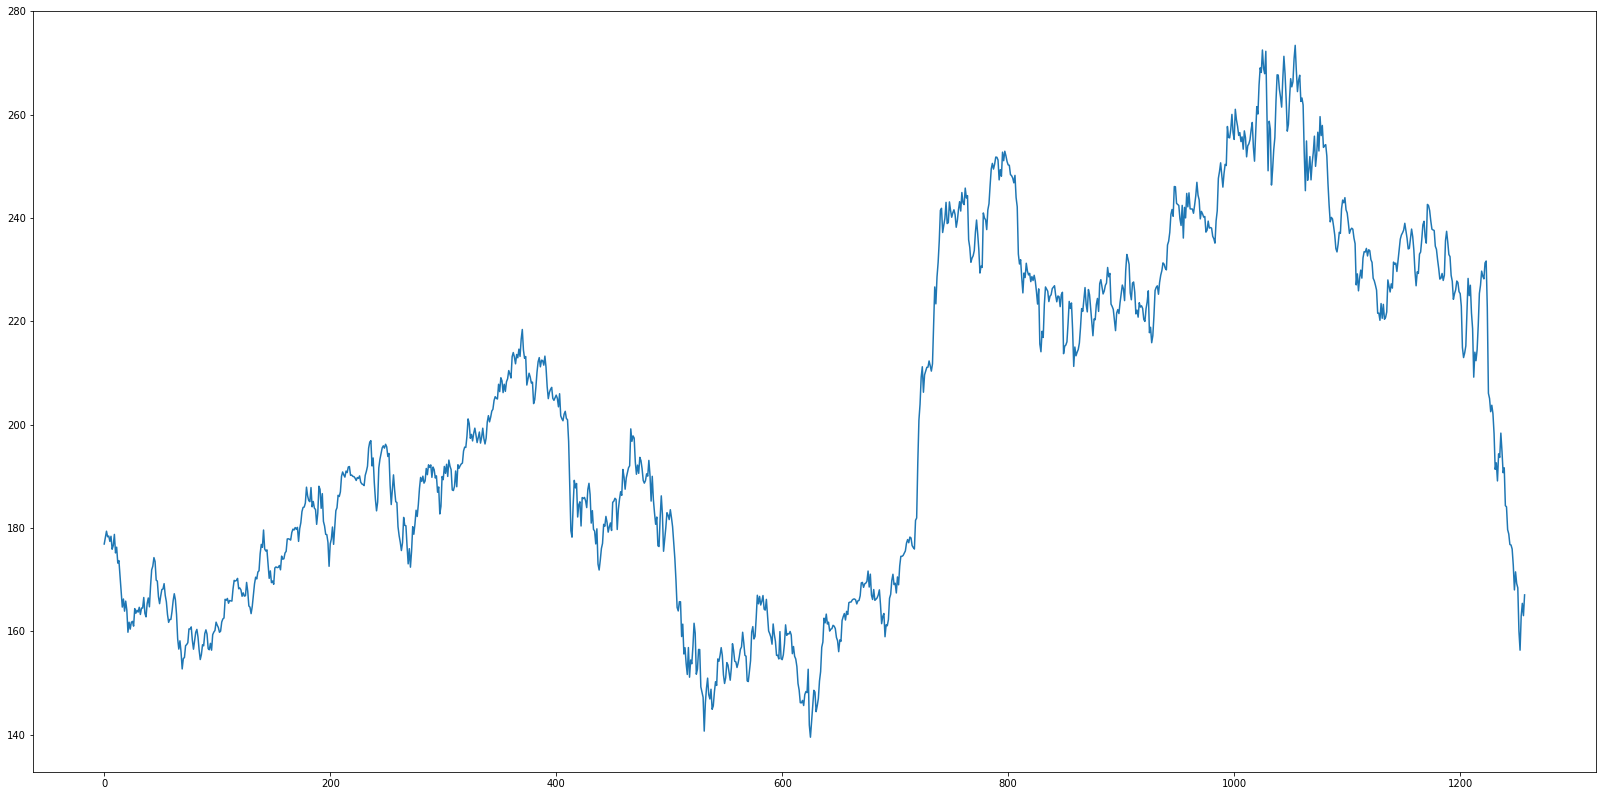

In [3]:
# Plot Closing Prices

plt.figure(figsize=(28,14))
plt.plot(GS_NN['Close'], label='Goldman Sachs Closing Price History')
plt.show

In [4]:
# Prepare new dataframe with 2 dimensions

data = GS_NN.sort_index(ascending=True, axis=0)
GS_ma_NN = data.filter(['Date', 'Close'], axis=1)

GS_ma_NN.head()

,Date,Close
0,2014-01-02,176.89
1,2014-01-03,178.15
2,2014-01-06,179.37
3,2014-01-07,178.29
4,2014-01-08,178.44


In [5]:
# Establish training and testing data ~60/40

GS_NN_train = GS_ma_NN[:1008]
GS_NN_test = GS_ma_NN[1008:]


In [6]:
# Fit data to model

GS_ma_NN.shape, GS_NN_train.shape, GS_NN_test.shape

((1258, 2), (1008, 2), (250, 2))

In [7]:
# Train for min and max

GS_NN_train['Date'].min(), GS_NN_train['Date'].max(), GS_NN_test['Date'].min(), GS_NN_test['Date'].max()

('2014-01-02', '2018-01-02', '2018-01-03', '2018-12-31')

In [8]:
# Make the Predictions

predictions = []

for i in range(0,250):
    a = GS_NN_train['Close'][len(GS_NN_train)-250+i].sum() + sum(predictions)
    b = a/250
    predictions.append(b)

In [9]:
# Root Mean Square Error

rmse = np.sqrt(np.mean(np.power((np.array(GS_NN_test['Close'])-predictions), 2)))
rmse

232.7675399772074

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


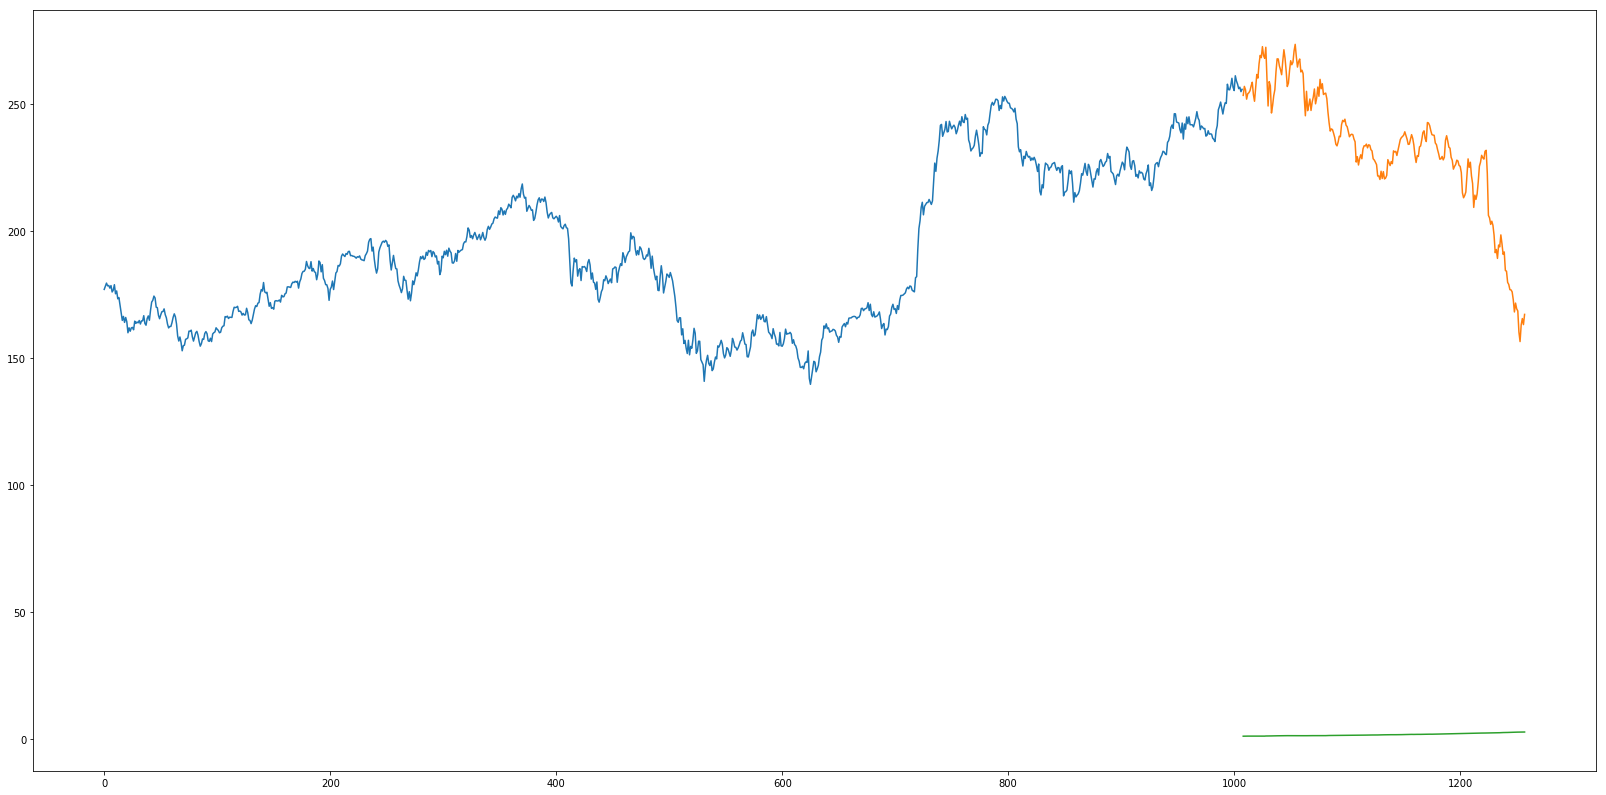

In [10]:
# Check the model via plot

GS_NN_test['Predictions'] = 0
GS_NN_test['Predictions'] = predictions

plt.figure(figsize=(28,14))
plt.plot(GS_NN_train['Close'])
plt.plot(GS_NN_test[['Close', 'Predictions']])

In [11]:
# Long Term Short Memory: Set up

data = GS_NN_df.sort_index(ascending=True, axis=0)
GS_prep = pd.DataFrame(index=range(0,len(GS_NN_df)), columns=['Date', 'Close'])

for i in range(0,len(data)):
    GS_prep['Date'][i] = data['Date'][i]
    GS_prep['Close'][i] = data['Close'][i]
    
GS_prep.index = GS_prep.Date
GS_prep.drop('Date', axis=1, inplace=True)

dataset = GS_prep.values

train = dataset[0:1008, :]
test = dataset[1008:, :]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [],[]
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
# Create and fit data to LSTM network

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

inputs = GS_prep[len(GS_prep) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 29s - loss: 0.0038


In [13]:
# Check results with RMSE

rmse = np.sqrt(np.mean(np.power((test-closing_price),2)))
rmse


7.098887661704051

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


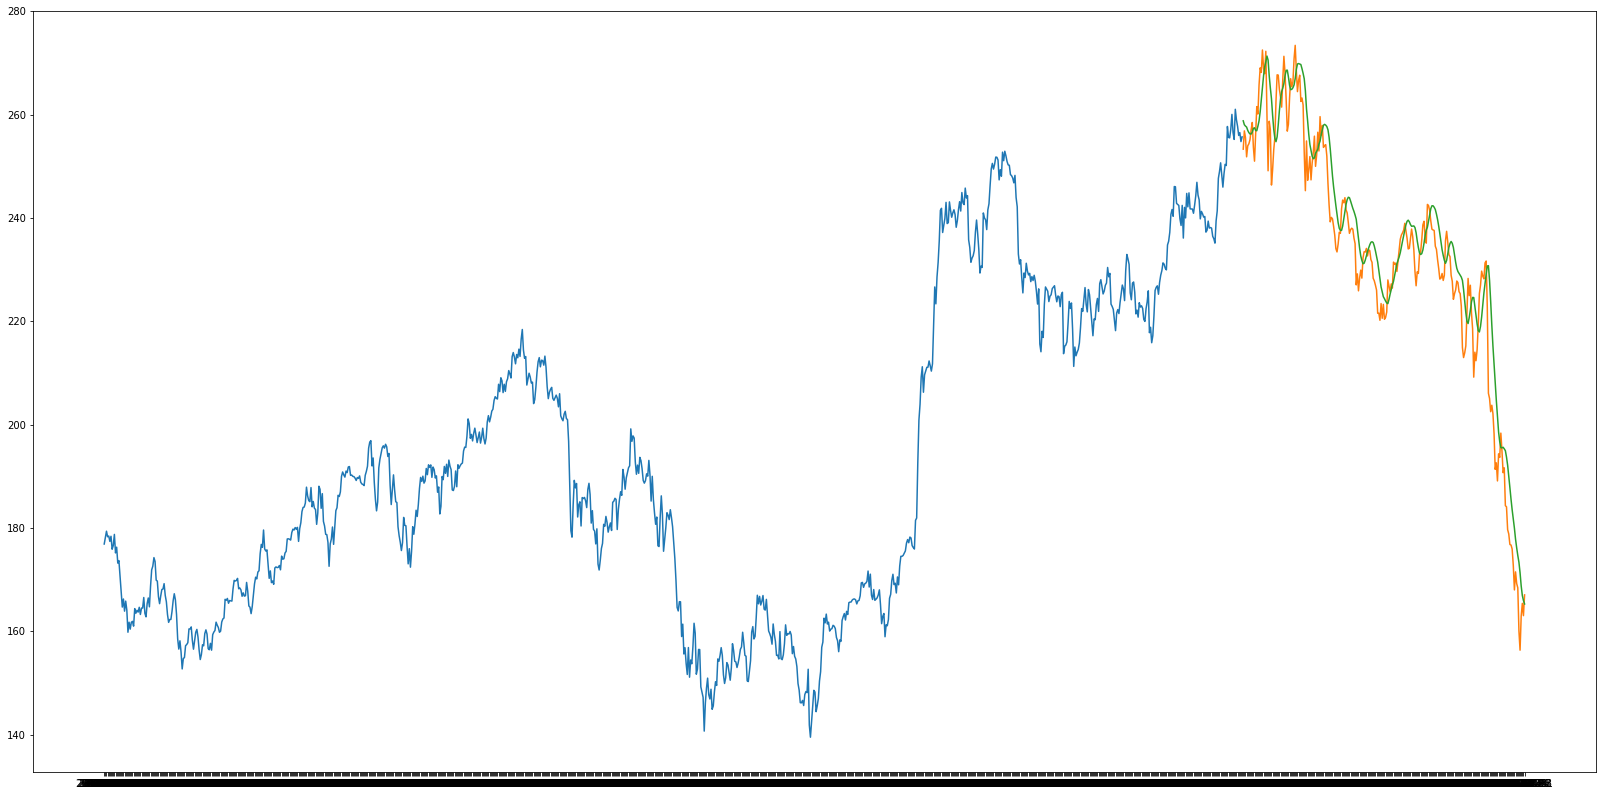

In [15]:
# Now plot

train = GS_prep[:1008]
test = GS_prep[1008:]

test['Predictions'] = closing_price

plt.figure(figsize=(28,14))
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])


In [17]:
test.head()

,Close,Predictions
Date,,
2018-01-03,253.29,258.777466
2018-01-04,256.83,258.021271
2018-01-05,255.52,257.756836
2018-01-08,251.81,257.559967
2018-01-09,253.94,256.929840
